<a href="https://colab.research.google.com/github/Khair1212/Hybrid_Product_Recommendation-LightFM/blob/main/Hybrid_Recommendation_using_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install the lightfm algorithm
!pip install lightfm

     |████████████████████████████████| 317kB 5.5MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705353 sha256=7af7ded7bf26a04b5afb3fecc50e5226fbaad5f497f9d160cbcb59f0411c1c70
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
#import necessary packages

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import os

from sklearn import preprocessing 
import keras as ks
import tensorflow

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM



In [ ]:
from google.colab import auth 
auth.authenticate_user() 
os.environ["PROJECT_ID"] = 'innate-portal-294200' 
 
import pandas_gbq 
transaction_data = 'SELECT * FROM `innate-portal-294200.ValueBase_Capstone.Transactions`' 
customer_info_data = 'SELECT * FROM `innate-portal-294200.ValueBase_Capstone.Customer_info`' 
product_info_data = 'SELECT * FROM `innate-portal-294200.ValueBase_Capstone.Product_cat_info`' 
tran_df = pandas_gbq.read_gbq(transaction_data,project_id = "innate-portal-294200") 
cust_df = pandas_gbq.read_gbq(customer_info_data,project_id = "innate-portal-294200")  
prod_df = pandas_gbq.read_gbq(product_info_data,project_id = "innate-portal-294200") 

Downloading: 100%|██████████| 23/23 [00:00<00:00, 134.48rows/s]


In [ ]:
tran_df.head() 

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,44016331022,269430,27-04-2012,4,1,1,100,10.5,110.5,e-Shop
1,97507207511,268867,30-03-2012,10,6,1,100,10.5,110.5,MBR
2,84441368903,267814,11/3/2012,3,5,1,100,10.5,110.5,Flagship store
3,23151091056,269500,23-11-2013,4,3,1,400,42.0,442.0,e-Shop
4,2820688369,269972,10/11/2013,1,1,1,400,42.0,442.0,Flagship store


In [ ]:
tran_df.sort_values(by = 'tran_date')   


,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
2298,76257166854,269407,1/1/2012,8,3,1,112,11.760,123.760,e-Shop
2043,30078154552,269151,1/1/2012,3,2,1,456,47.880,503.880,e-Shop
6933,41901986246,269269,1/1/2012,7,5,2,1122,235.620,2479.620,MBR
21238,78865860112,271275,1/1/2012,3,1,-5,-1344,705.600,-7425.600,TeleShop
4883,66067413087,268571,1/1/2012,9,3,2,693,145.530,1531.530,e-Shop
...,...,...,...,...,...,...,...,...,...,...
18824,48212686413,273400,9/9/2013,4,4,5,1257,659.925,6944.925,MBR
13452,4381196320,274804,9/9/2013,1,1,4,1345,564.900,5944.900,e-Shop
3017,19282108296,273266,9/9/2013,10,5,1,1278,134.190,1412.190,e-Shop
10051,99925193648,268376,9/9/2013,11,5,3,85,26.775,281.775,e-Shop


In [ ]:
print(cust_df.head())
print(cust_df.shape) 

   customer_Id        DOB Gender  city_code
0       267199 1970-02-14   None        2.0
1       271626 1970-06-02   None        6.0
2       268709 1970-09-09      F        NaN
3       270324 1970-02-01      F        1.0
4       272028 1970-02-20      F        1.0
(5647, 4)


In [ ]:
print(prod_df.head())
print(prod_df.shape)

   prod_cat_code  prod_cat  prod_sub_cat_code prod_subcat
0              1  Clothing                  4        Mens
1              1  Clothing                  1       Women
2              1  Clothing                  3        Kids
3              2  Footwear                  1        Mens
4              2  Footwear                  3       Women
(23, 4)


In [ ]:
#Rename the column for more clarity and future merging 

tran_df.columns = ['Transaction ID', 'Customer ID', 'Transaction Date', 'Prod Subcat Code',
       'Prod Cat Code', 'Qty', 'Rate', 'Tax', 'Total Amt', 'Store Type']
cust_df.columns = ['Customer ID', 'DOB', 'Gender', 'City Code']

prod_df.columns = ['Prod Cat Code', 'Prod Cat', 'Prod Subcat Code', 'Prod Subcat']

# EDA (Exploratory Data Analysis) [Transaction Data]

In [ ]:
tran_df2 = tran_df.copy()
cust_df2 = cust_df.copy()
prod_df2 = prod_df.copy()

In [ ]:
tran_df2.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type
0,44016331022,269430,27-04-2012,4,1,1,100,10.5,110.5,e-Shop
1,97507207511,268867,30-03-2012,10,6,1,100,10.5,110.5,MBR
2,84441368903,267814,11/3/2012,3,5,1,100,10.5,110.5,Flagship store
3,23151091056,269500,23-11-2013,4,3,1,400,42.0,442.0,e-Shop
4,2820688369,269972,10/11/2013,1,1,1,400,42.0,442.0,Flagship store


In [ ]:
tran_df2.isnull().sum()

Transaction ID      0
Customer ID         0
Transaction Date    0
Prod Subcat Code    0
Prod Cat Code       0
Qty                 0
Rate                0
Tax                 0
Total Amt           0
Store Type          0
dtype: int64

In [ ]:
#remove inappropriate rows
tran_df2 = tran_df2[tran_df2['Total Amt'] > 0] 

In [ ]:
tran_df2 

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type
0,44016331022,269430,27-04-2012,4,1,1,100,10.500,110.500,e-Shop
1,97507207511,268867,30-03-2012,10,6,1,100,10.500,110.500,MBR
2,84441368903,267814,11/3/2012,3,5,1,100,10.500,110.500,Flagship store
3,23151091056,269500,23-11-2013,4,3,1,400,42.000,442.000,e-Shop
4,2820688369,269972,10/11/2013,1,1,1,400,42.000,442.000,Flagship store
...,...,...,...,...,...,...,...,...,...,...
20871,46591907261,273248,25-08-2011,10,5,5,792,415.800,4375.800,MBR
20872,51141103524,271459,28-06-2011,5,3,5,792,415.800,4375.800,Flagship store
20873,57159189042,267143,31-03-2013,10,6,5,1219,639.975,6734.975,Flagship store
20874,21904499602,268544,15-01-2013,1,1,5,1219,639.975,6734.975,e-Shop


In [ ]:
tran_df2.head() 

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type
0,44016331022,269430,27-04-2012,4,1,1,100,10.5,110.5,e-Shop
1,97507207511,268867,30-03-2012,10,6,1,100,10.5,110.5,MBR
2,84441368903,267814,11/3/2012,3,5,1,100,10.5,110.5,Flagship store
3,23151091056,269500,23-11-2013,4,3,1,400,42.0,442.0,e-Shop
4,2820688369,269972,10/11/2013,1,1,1,400,42.0,442.0,Flagship store


In [ ]:
tran_df2['Transaction Date'] = pd.to_datetime(tran_df2['Transaction Date'],dayfirst = True)  

In [ ]:
#Calculate netsales, without Tax
tran_df2['Net_Sales'] = tran_df2['Qty'] * tran_df2['Rate'] 

In [ ]:
#tran_df2['Material'] = tran_df2['Prod Cat Code'].astype('str') + '_' + tran_df2['Prod Subcat Code'].astype('str') + '_' + tran_df2['Store Type'].astype(str)  

In [ ]:
tran_df2 

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
0,44016331022,269430,2012-04-27,4,1,1,100,10.500,110.500,e-Shop,100
1,97507207511,268867,2012-03-30,10,6,1,100,10.500,110.500,MBR,100
2,84441368903,267814,2012-03-11,3,5,1,100,10.500,110.500,Flagship store,100
3,23151091056,269500,2013-11-23,4,3,1,400,42.000,442.000,e-Shop,400
4,2820688369,269972,2013-11-10,1,1,1,400,42.000,442.000,Flagship store,400
...,...,...,...,...,...,...,...,...,...,...,...
20871,46591907261,273248,2011-08-25,10,5,5,792,415.800,4375.800,MBR,3960
20872,51141103524,271459,2011-06-28,5,3,5,792,415.800,4375.800,Flagship store,3960
20873,57159189042,267143,2013-03-31,10,6,5,1219,639.975,6734.975,Flagship store,6095
20874,21904499602,268544,2013-01-15,1,1,5,1219,639.975,6734.975,e-Shop,6095


# EDA (Exploratory Data Analysis) [Product Data]

In [ ]:
prod_df2.head() 

,Prod Cat Code,Prod Cat,Prod Subcat Code,Prod Subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [ ]:
prod_df2.groupby('Prod Cat Code')['Prod Cat'].value_counts()

Prod Cat Code  Prod Cat        
1              Clothing            3
2              Footwear            3
3              Electronics         5
4              Bags                2
5              Books               6
6              Home and kitchen    4
Name: Prod Cat, dtype: int64

In [ ]:
prod_df2.groupby('Prod Subcat Code')['Prod Subcat'].value_counts()

Prod Subcat Code  Prod Subcat        
1                 Mens                   2
                  Women                  1
2                 Furnishing             1
3                 Comics                 1
                  Kids                   1
                  Women                  1
4                 Kids                   1
                  Mens                   1
                  Mobiles                1
                  Women                  1
5                 Computers              1
6                 DIY                    1
7                 Fiction                1
8                 Personal Appliances    1
9                 Cameras                1
10                Audio and video        1
                  Kitchen                1
                  Non-Fiction            1
11                Bath                   1
                  Children               1
12                Academic               1
                  Tools                  1
Name: Prod Subca

In [ ]:
prod_df2['Product Info'] = prod_df2['Prod Cat'].astype(str) + '_'+ prod_df2['Prod Subcat'].astype(str)

In [ ]:
prod_df2['Product Code'] = prod_df2['Prod Cat Code'].astype(str) + '_'+ prod_df2['Prod Subcat Code'].astype(str)  

In [ ]:
prod_df2.head()

,Prod Cat Code,Prod Cat,Prod Subcat Code,Prod Subcat,Product Info,Product Code
0,1,Clothing,4,Mens,Clothing_Mens,1_4
1,1,Clothing,1,Women,Clothing_Women,1_1
2,1,Clothing,3,Kids,Clothing_Kids,1_3
3,2,Footwear,1,Mens,Footwear_Mens,2_1
4,2,Footwear,3,Women,Footwear_Women,2_3


#RFM

In [ ]:
tran_df2.shape

(20876, 11)

In [ ]:
tran_df2.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
0,44016331022,269430,2012-04-27,4,1,1,100,10.5,110.5,e-Shop,100
1,97507207511,268867,2012-03-30,10,6,1,100,10.5,110.5,MBR,100
2,84441368903,267814,2012-03-11,3,5,1,100,10.5,110.5,Flagship store,100
3,23151091056,269500,2013-11-23,4,3,1,400,42.0,442.0,e-Shop,400
4,2820688369,269972,2013-11-10,1,1,1,400,42.0,442.0,Flagship store,400


In [ ]:
for i in tran_df2.columns: 
  print(i, ':', tran_df2[i].nunique()) 

Transaction ID : 20876
Customer ID : 5506
Transaction Date : 1123
Prod Subcat Code : 12
Prod Cat Code : 6
Qty : 5
Rate : 1431
Tax : 4194
Total Amt : 4194
Store Type : 4
Net_Sales : 4194


In [ ]:
tran_df2['Transaction Date'].max() 

Timestamp('2014-02-20 00:00:00')

In [ ]:
#Fix Today
import datetime as dt 

Now = dt.datetime(2014,12,3) #YYYY-MM-DD 

In [ ]:
#Recency
RFM = tran_df2.groupby('Customer ID').agg({'Transaction Date':lambda x: (Now - x.max()).days}) 


In [ ]:
#Frequency
RFM['Frequency'] = tran_df2.groupby('Customer ID').agg({'Transaction ID':lambda x: len(x)}) 


In [ ]:
#Monetary
RFM['Monetary'] = tran_df2.groupby('Customer ID').agg({'Net_Sales':lambda x: sum(x)})


In [ ]:
RFM = RFM.rename(columns = {'Transaction Date': 'Recency'})                     

In [ ]:
RFM = RFM.drop_duplicates()

In [ ]:
print(RFM['Frequency'].max())
print(RFM['Monetary'].max())
print(RFM['Recency'].max())

11
40695
1407


In [ ]:
RFM['recency_normalized']=pd.qcut(RFM['Recency'],5,labels=False)
RFM['recency_normalized']= RFM['recency_normalized']+1
RFM['frequency_normalized']=pd.qcut(RFM['Frequency'],5,labels=False)
RFM['frequency_normalized']=RFM['frequency_normalized']+1
RFM['monetary_value_normalized']=pd.qcut(RFM['Monetary'],5,labels=False)
RFM['monetary_value_normalized']=RFM['monetary_value_normalized']+1 

In [ ]:
RFM

,Recency,Frequency,Monetary,recency_normalized,frequency_normalized,monetary_value_normalized
Customer ID,,,,,,
266783,651,4,8102,4,3,3
266784,729,3,5153,4,2,2
266785,489,7,25740,3,5,5
266788,659,4,5514,4,3,2
266794,294,11,25446,1,5,5
...,...,...,...,...,...,...
275257,457,4,12421,3,3,4
275261,424,3,3353,2,2,1
275262,1008,2,4596,5,1,2


In [ ]:
RFM_Array  = np.array(RFM.iloc[:,3:6]) 
RFM_NORM = preprocessing.normalize(RFM_Array)

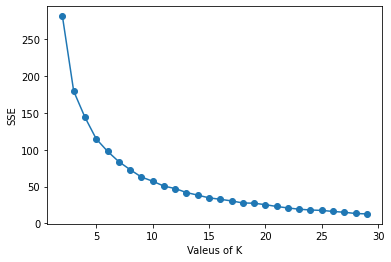

In [ ]:
# Elbow method
import matplotlib.pyplot as plt

Ks = range(2,30)

results = []

for k in Ks:
  model = KMeans(n_clusters= k)
  model.fit(RFM_NORM)

  results.append(model.inertia_)

plt.plot(Ks, results, 'o-')
plt.xlabel('Valeus of K')
plt.ylabel('SSE')
plt.show() 

In [ ]:
from sklearn.cluster import KMeans

# Creating our Model
kmeans = KMeans(n_clusters = 5) 

# Training our model 
kmeans.fit(RFM_NORM)  

# You can see the labels (clusters) assigned for each data point with the function labels_ 
kmeans.labels_ 

# Assigning the labels to the initial dataset 
RFM['Cluster'] = kmeans.labels_ 

In [ ]:
RFM

,Recency,Frequency,Monetary,recency_normalized,frequency_normalized,monetary_value_normalized,Cluster
Customer ID,,,,,,,
266783,651,4,8102,4,3,3,0
266784,729,3,5153,4,2,2,0
266785,489,7,25740,3,5,5,3
266788,659,4,5514,4,3,2,0
266794,294,11,25446,1,5,5,1
...,...,...,...,...,...,...,...
275257,457,4,12421,3,3,4,4
275261,424,3,3353,2,2,1,3
275262,1008,2,4596,5,1,2,2


In [ ]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(RFM.Cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM[RFM.Cluster == C]['recency_normalized'],
                                y = RFM[RFM.Cluster == C]['frequency_normalized'],
                                z = RFM[RFM.Cluster == C]['monetary_value_normalized'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'RFM Segment ' + str(C)))

In [ ]:
PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Monetary Value', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
RFM['Cluster']

Customer ID
266783    3
266784    3
266785    6
266788    3
266794    1
         ..
275257    6
275261    3
275262    5
275264    0
275265    0
Name: Cluster, Length: 5506, dtype: int32

# Recommendation

In [ ]:
rm_df = RFM.copy() 

In [ ]:
rm_df.head()

,Recency,Frequency,Monetary,recency_normalized,frequency_normalized,monetary_value_normalized,Cluster
Customer ID,,,,,,,
266783,651,4,8102,4,3,3,0
266784,729,3,5153,4,2,2,0
266785,489,7,25740,3,5,5,3
266788,659,4,5514,4,3,2,0
266794,294,11,25446,1,5,5,1


In [ ]:
pd.DataFrame(tran_df.groupby('Customer ID')['Transaction ID'].count()).sort_values(by = 'Transaction ID', ascending=False) 

,Transaction ID
Customer ID,
269449,13
268819,13
273014,12
266794,12
272286,12
...,...
271072,1
273975,1
271060,1


In [ ]:
rm_df

In [ ]:
# merge cluster
rm_df2 = tran_df2.merge(rm_df['Cluster'], how = 'left', on = 'Customer ID')
#remove null entries on clusters (if any)
#rm_df2 = rm_df2[rm_df2['Cluster'].notnull()]

#merge customer city
rm_df2 = rm_df2.merge(cust_df2[['Customer ID','City Code', 'Gender']], how='left', on = 'Customer ID')

#merge product cat
#rm_df2 = rm_df2.merge(prod_df2[['Prod Cat Code','Prod Subcat']], how = 'left', on = 'Prod Cat Code')
#rm_df2 = rm_df2.merge(prod_df2[['Prod Subcat Code', 'Prod Cat']], how = 'left', on = 'Prod Subcat Code')


In [ ]:
rm_df2['Product Code'] = rm_df2['Prod Cat Code'].astype(str) + '_'+ rm_df2['Prod Subcat Code'].astype(str)


In [ ]:
rm_df2 = rm_df2.merge(prod_df2[['Product Code','Product Info']], how='left', on = 'Product Code')


In [ ]:
 rm_df2

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales,Cluster,City Code,Gender,Product Code,Product Info
0,44016331022,269430,2012-04-27,4,1,1,100,10.500,110.500,e-Shop,100,2,5.0,F,1_4,Clothing_Mens
1,97507207511,268867,2012-03-30,10,6,1,100,10.500,110.500,MBR,100,3,4.0,F,6_10,Home and kitchen_Kitchen
2,84441368903,267814,2012-03-11,3,5,1,100,10.500,110.500,Flagship store,100,1,7.0,F,5_3,Books_Comics
3,23151091056,269500,2013-11-23,4,3,1,400,42.000,442.000,e-Shop,400,3,10.0,M,3_4,Electronics_Mobiles
4,2820688369,269972,2013-11-10,1,1,1,400,42.000,442.000,Flagship store,400,3,3.0,M,1_1,Clothing_Women
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20871,46591907261,273248,2011-08-25,10,5,5,792,415.800,4375.800,MBR,3960,0,9.0,F,5_10,Books_Non-Fiction
20872,51141103524,271459,2011-06-28,5,3,5,792,415.800,4375.800,Flagship store,3960,4,8.0,M,3_5,Electronics_Computers
20873,57159189042,267143,2013-03-31,10,6,5,1219,639.975,6734.975,Flagship store,6095,0,1.0,F,6_10,Home and kitchen_Kitchen
20874,21904499602,268544,2013-01-15,1,1,5,1219,639.975,6734.975,e-Shop,6095,0,3.0,F,1_1,Clothing_Women


In [ ]:
len(rm_df2),len(rm_df2['Customer ID'].unique()), len(rm_df2['Transaction ID'].unique())

(20876, 5506, 20876)

In [ ]:
#Keep only essential columns
final_rm_df = rm_df2.copy() 
final_rm_df = final_rm_df[['Product Info','Product Code','Store Type', 'Qty', 'Customer ID', 'Gender', 'Cluster']]

In [ ]:
final_rm_df['Material'] = final_rm_df['Product Info'].astype(str) + '_'+ final_rm_df['Store Type'].astype(str)


In [ ]:
final_rm_df.isnull().sum()

Product Info    0
Product Code    0
Store Type      0
Qty             0
Customer ID     0
Gender          8
Cluster         0
Material        0
dtype: int64

In [ ]:
final_rm_df = final_rm_df.dropna()

In [ ]:
final_rm_df.isnull().sum()

Product Info    0
Product Code    0
Store Type      0
Qty             0
Customer ID     0
Gender          0
Cluster         0
Material        0
dtype: int64

In [ ]:
#Interacion Matrix
#Getting the Customer's transaction for every material in terms of sales quantity
interactions = final_rm_df.groupby(['Customer ID', 'Material'])['Qty'].sum().unstack()  

In [ ]:
interactions = interactions.fillna(0) 

In [ ]:
minmaxscaler = preprocessing.MinMaxScaler() 
interactions_scaled = minmaxscaler.fit_transform(interactions) 
interactions_scaled = pd.DataFrame(interactions_scaled) 

In [ ]:
## we re-append the customer ID and the material into the DataFrame's index and column respectively
interactions_scaled.index = interactions.index 
interactions_scaled.columns = interactions.columns 

In [ ]:
interactions_scaled 

Material,Bags_Mens_Flagship store,Bags_Mens_MBR,Bags_Mens_TeleShop,Bags_Mens_e-Shop,Bags_Women_Flagship store,Bags_Women_MBR,Bags_Women_TeleShop,Bags_Women_e-Shop,Books_Academic_Flagship store,Books_Academic_MBR,Books_Academic_TeleShop,Books_Academic_e-Shop,Books_Children_Flagship store,Books_Children_MBR,Books_Children_TeleShop,Books_Children_e-Shop,Books_Comics_Flagship store,Books_Comics_MBR,Books_Comics_TeleShop,Books_Comics_e-Shop,Books_DIY_Flagship store,Books_DIY_MBR,Books_DIY_TeleShop,Books_DIY_e-Shop,Books_Fiction_Flagship store,Books_Fiction_MBR,Books_Fiction_TeleShop,Books_Fiction_e-Shop,Books_Non-Fiction_Flagship store,Books_Non-Fiction_MBR,Books_Non-Fiction_TeleShop,Books_Non-Fiction_e-Shop,Clothing_Kids_Flagship store,Clothing_Kids_MBR,Clothing_Kids_TeleShop,Clothing_Kids_e-Shop,Clothing_Mens_Flagship store,Clothing_Mens_MBR,Clothing_Mens_TeleShop,Clothing_Mens_e-Shop,...,Electronics_Computers_Flagship store,Electronics_Computers_MBR,Electronics_Computers_TeleShop,Electronics_Computers_e-Shop,Electronics_Mobiles_Flagship store,Electronics_Mobiles_MBR,Electronics_Mobiles_TeleShop,Electronics_Mobiles_e-Shop,Electronics_Personal Appliances_Flagship store,Electronics_Personal Appliances_MBR,Electronics_Personal Appliances_TeleShop,Electronics_Personal Appliances_e-Shop,Footwear_Kids_Flagship store,Footwear_Kids_MBR,Footwear_Kids_TeleShop,Footwear_Kids_e-Shop,Footwear_Mens_Flagship store,Footwear_Mens_MBR,Footwear_Mens_TeleShop,Footwear_Mens_e-Shop,Footwear_Women_Flagship store,Footwear_Women_MBR,Footwear_Women_TeleShop,Footwear_Women_e-Shop,Home and kitchen_Bath_Flagship store,Home and kitchen_Bath_MBR,Home and kitchen_Bath_TeleShop,Home and kitchen_Bath_e-Shop,Home and kitchen_Furnishing_Flagship store,Home and kitchen_Furnishing_MBR,Home and kitchen_Furnishing_TeleShop,Home and kitchen_Furnishing_e-Shop,Home and kitchen_Kitchen_Flagship store,Home and kitchen_Kitchen_MBR,Home and kitchen_Kitchen_TeleShop,Home and kitchen_Kitchen_e-Shop,Home and kitchen_Tools_Flagship store,Home and kitchen_Tools_MBR,Home and kitchen_Tools_TeleShop,Home and kitchen_Tools_e-Shop
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
266783,0.0,0.000000,0.000,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.428571,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
266784,0.0,0.000000,0.000,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.555556,0.0,0.0,0.428571,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
266785,0.0,0.000000,0.375,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.625,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
266788,0.0,0.285714,0.000,0.000000,0.0,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
266794,0.0,0.000000,0.000,0.222222,0.0,0.375,0.000000,0.0,0.0,0.8,0.0,0.0,0.0,0.000000,0.0,0.3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0

In [ ]:
### User Features Matrix 
## There are two features that is used to build the user matrix here
## First is the customer's unique categories they buy 
## Second is the clusters they belong to

# Getting the unique categories they buy
# grouped them by the quantity per category
cust_qty = final_rm_df.groupby(['Customer ID', 'Product Info'])['Qty'].sum().unstack().fillna(0)


In [ ]:
# Scaled value of the categories
# Scale value of the interaction matrix using sklearn.preprocessing.MinMaxScaler 
minmaxscaler = preprocessing.MinMaxScaler()
cust_qty_scaled = minmaxscaler.fit_transform(cust_qty)
cust_qty_scaled = pd.DataFrame(cust_qty_scaled)
cust_qty_scaled.index = cust_qty.index
cust_qty_scaled.columns = cust_qty.columns

In [ ]:
cust_clus = final_rm_df.groupby(['Customer ID', 'Cluster'])['Cluster'].nunique().unstack().fillna(0)

cust_gender = final_rm_df.groupby(['Customer ID', 'Gender'])['Gender'].nunique().unstack().fillna(0)
print(cust_gender.shape)
print(cust_clus.shape)

(5504, 2)
(5504, 5)


In [ ]:
temp_df = pd.merge(cust_clus, cust_gender, left_index=True, right_index=True, how='inner')
temp_df

,0,1,2,3,4,F,M
Customer ID,,,,,,,
266783,1.0,0.0,0.0,0.0,0.0,0.0,1.0
266784,1.0,0.0,0.0,0.0,0.0,1.0,0.0
266785,0.0,0.0,0.0,1.0,0.0,1.0,0.0
266788,1.0,0.0,0.0,0.0,0.0,1.0,0.0
266794,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
275257,0.0,0.0,0.0,0.0,1.0,0.0,1.0
275261,0.0,0.0,0.0,1.0,0.0,1.0,0.0
275262,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# Merge the two features to create the user feature matrix
#customer_features = pd.merge(cust_qty_scaled, cust_gender, left_index=True, right_index=True, how='inner')
#print(customer_features)
customer_features = pd.merge(cust_qty_scaled, temp_df, left_index=True, right_index=True, how='inner')
print(customer_features)
customer_features = customer_features.rename(columns={0: 'Cluster 0', 
                                                      1: 'Cluster 1', 
                                                      2: 'Cluster 2', 
                                                      3: 'Cluster 3', 
                                                      4: 'Cluster 4',
                                                      })

             Bags_Mens  Bags_Women  Books_Academic  ...    4    F    M
Customer ID                                         ...               
266783             0.0    0.000000             0.0  ...  0.0  0.0  1.0
266784             0.0    0.000000             0.0  ...  0.0  1.0  0.0
266785             0.3    0.000000             0.0  ...  0.0  1.0  0.0
266788             0.2    0.000000             0.0  ...  0.0  1.0  0.0
266794             0.2    0.272727             0.4  ...  0.0  1.0  0.0
...                ...         ...             ...  ...  ...  ...  ...
275257             0.0    0.000000             0.0  ...  1.0  0.0  1.0
275261             0.0    0.090909             0.0  ...  0.0  1.0  0.0
275262             0.0    0.000000             0.0  ...  0.0  0.0  1.0
275264             0.0    0.000000             0.0  ...  0.0  0.0  1.0
275265             0.1    0.000000             0.3  ...  0.0  0.0  1.0

[5504 rows x 30 columns]


In [ ]:
customer_features

,Bags_Mens,Bags_Women,Books_Academic,Books_Children,Books_Comics,Books_DIY,Books_Fiction,Books_Non-Fiction,Clothing_Kids,Clothing_Mens,Clothing_Women,Electronics_Audio and video,Electronics_Cameras,Electronics_Computers,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,F,M
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
266783,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.2,0.000000,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0
266784,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.384615,0.3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.166667,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
266785,0.3,0.000000,0.0,0.454545,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.7,0.666667,0.000000,0.0,0.0,0.416667,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
266788,0.2,0.000000,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.4,0.083333,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0
266794,0.2,0.272727,0.4,0.272727,0.000000,0.0,0.000000,0.0,0.583333,0.000000,0.0,0.214286,0.000000,0.0,0.000000,0.363636,0.0,0.000000,0.416667,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275257,0.0,0.000000,0.0,0.272727,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.071429,0.000000,0.0,0.000000,0.000000,0.0,0.416667,0.000000,0.0,0.3,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0
275261,0.0,0.090909,0.0,0.454545,0.272727,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
275262,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.250000,0.0,0.000000,0.181818,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
### Item Features Matrix
## We use the different categories of the items as the feature to build the item feature matrix here

item_category = pd.DataFrame(final_rm_df.groupby(['Material', 
                                              'Product Info'])['Qty'].sum().unstack().fillna(0).reset_index().set_index('Material'))
# item_cat = item_cat.applymap(replaceneg0)

# Scaled value of the item categories
minmaxscaler = preprocessing.MinMaxScaler()
item_category_scaled = minmaxscaler.fit_transform(item_category)
item_category_scaled = pd.DataFrame(item_category_scaled)
item_category_scaled.index = item_category.index
item_category_scaled.columns = item_category.columns

In [ ]:
item_category_scaled

Product Info,Bags_Mens,Bags_Women,Books_Academic,Books_Children,Books_Comics,Books_DIY,Books_Fiction,Books_Non-Fiction,Clothing_Kids,Clothing_Mens,Clothing_Women,Electronics_Audio and video,Electronics_Cameras,Electronics_Computers,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools
Material,,,,,,,,,,,,,,,,,,,,,,,
Bags_Mens_Flagship store,0.515474,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bags_Mens_MBR,0.528046,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bags_Mens_TeleShop,0.539652,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bags_Mens_e-Shop,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
Bags_Women_Flagship store,0.000000,0.518448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Home and kitchen_Kitchen_e-Shop,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
Home and kitchen_Tools_Flagship store,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428340
Home and kitchen_Tools_MBR,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454251


In [ ]:
### We have three features as required by TensorRec

## Create COOMatrices using Scipy function 
## COOMatrices are sparse matrices, mostly filled with zero
## It speeds up the processes and saves a lot of memory
interaction_f = sparse.coo_matrix(interactions_scaled)  
user_f  = sparse.coo_matrix(customer_features) 
item_f  = sparse.coo_matrix(item_category_scaled) 

In [ ]:
interaction_f 

<5504x92 sparse matrix of type '<class 'numpy.float64'>'
	with 20386 stored elements in COOrdinate format>

In [ ]:
### Jesse Steinweg-Woods provide a great elaboration on Recommendation metrics
### The following code is borrowed from his work
### https://jessesw.com/Rec-System/

def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased
    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask], 
                                       (interactions.row[not_mask], 
                                        interactions.col[not_mask])), 
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [ ]:
mask_size = len(interaction_f.data)

### use numpy.random.choice to generate a random True/False array, where False denotes the "masked" interactions (hidden)
## https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8]) 

array([False,  True,  True, ...,  True,  True,  True])

In [ ]:
# Create a masked train and test dataset of the interaction features
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

In [ ]:
## validate that the interactions are scipy coordinate sparse matrix

train_interactions

<5506x92 sparse matrix of type '<class 'numpy.float64'>'
	with 16195 stored elements in COOrdinate format>

In [ ]:
#tuning process
train_auc = []
test_auc = []
parameter = []
loss = 'warp'
learning_rate = [0.1]
no_components = [50,100]
epochs = [50]
for i in learning_rate:
  for j in no_components:
    model = LightFM(loss='warp', random_state = 2021,
                    learning_rate = i, no_components = j)
    
    for k in epochs:
      model = model.fit(train_interactions,
                  item_features = item_features, 
                  user_features = user_features, 
                  epochs=k,
                  num_threads= 8, verbose=True)
      
      train_auc.append(calculate_auc_score(model, train_interactions, item_f, user_f)) 
      test_auc.append(calculate_auc_score(model, test_interactions, item_f, user_f)) 
      parameter.append('learning rate: '+str(i)+', no_components: '+str(j)+ ', epochs:'+ str(k)) 

In [ ]:
train_auc
max(test_auc)
#train_auc.index(0.9474824)
train_auc
np.argmax(test_auc)
parameter[1]

'learning rate: 0.1, no_components: 100, epochs:50'

In [ ]:
#tuning process
train_auc = []
test_auc = []
parameters = []
loss = 'warp'
learning_rate = [0.1, 0.01, 0.001, 0.5]
no_components = [50,100,150,200,300,500]
epochs = [50,100,200,300,500]
for i in learning_rate:
  for j in no_components:
    model = LightFM(loss='warp', random_state = 42,
                    learning_rate = i, no_components = j)
    
    for k in epochs: 
      model = model.fit(train_interactions, 
                  item_features = item_features, 
                  user_features = user_features,  
                  epochs=k, 
                  num_threads= 8, verbose=True) 
      
      train_auc.append(calculate_auc_score(model, train_interactions, item_f, user_f))
      test_auc.append(calculate_auc_score(model, test_interactions, item_f, user_f))
      parameters.append('learning rate: '+str(i)+', no_components: '+str(j)+ ', epochs:'+ str(k)) 

Streaming output truncated to the last 5000 lines.
Epoch: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]

Epoch: 100%|██████████| 50/50 [00:12<00:00,  3.94it/s]

Epoch: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]

Epoch: 100%|██████████| 200/200 [00:49<00:00,  4.08it/s]

Epoch: 100%|██████████| 300/300 [01:12<00:00,  4.16it/s]

Epoch: 100%|██████████| 500/500 [01:58<00:00,  4.23it/s]

Epoch: 100%|██████████| 50/50 [00:15<00:00,  3.20it/s]

Epoch: 100%|██████████| 100/100 [00:31<00:00,  3.21it/s]

Epoch: 100%|██████████| 200/200 [01:01<00:00,  3.27it/s]

Epoch: 100%|██████████| 300/300 [01:29<00:00,  3.34it/s]

Epoch: 100%|██████████| 500/500 [02:24<00:00,  3.45it/s]

Epoch: 100%|██████████| 50/50 [00:22<00:00,  2.20it/s]

Epoch: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]

Epoch: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]

Epoch: 100%|██████████| 300/300 [02:05<00:00,  2.39it/s]

Epoch: 100%|██████████| 500/500 [03:21<00:00,  2.48it/s]

Epoch: 100%|██████████| 50/

In [ ]:


model = LightFM(loss='warp',
                random_state=  ,
                learning_rate=0.90,
                no_components=150,
                )

model = model.fit(train_interactions,
                  item_features = item_features, 
                  user_features = user_features, 
                  epochs=100,
                  num_threads= 8, verbose=True)

Epoch: 100%|██████████| 100/100 [00:14<00:00,  6.70it/s]


In [ ]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score


def calculate_auc_score(lightfm_model, interactions_matrix, 
                        question_features, professional_features): 
    """
    Measure the ROC AUC metric for a model. 
    A perfect score is 1.0.

    Parameters
    ----------
    lightfm_model: LightFM model 
        A fitted lightfm model 
    interactions_matrix : 
        A lightfm interactions matrix 
    question_features, professional_features: 
        Lightfm features 
        
    Returns
    -------
    String containing AUC score 
    """
    score = auc_score( 
        lightfm_model, interactions_matrix, 
        item_features=question_features, 
        user_features=professional_features, 
        num_threads=4).mean()
    return score

print(calculate_auc_score(model, train_interactions, item_f, user_f))
print(calculate_auc_score(model, test_interactions, item_f, user_f))

0.91461843
0.88683033


In [ ]:
final_rm_df['Material ID'] = final_rm_df['Material'].factorize()[0]

In [ ]:
def prediction(customer_ids):
  for customer in customer_ids:
    
    print('Customer ID: (', customer, ''') \n 
                Previous Purchase''' )
    print('=====================================================')
    print(final_rm_df[final_rm_df['Customer ID'] == customer][['Material', 'Qty']].sort_values(by = 'Qty', ascending = False).to_string(index = False))
    
    discard_item_id = final_rm_df[final_rm_df['Customer ID'] == customer]['Material ID'].values.tolist() 
    pred_prod = final_rm_df[['Material ID', 'Material']]
    pred_prod = pred_prod[~pred_prod['Material ID'].isin(discard_item_id)]
    pred_prod = pred_prod.drop_duplicates().reset_index().drop('index', axis=1)
    item_ids = pred_prod['Material ID'].unique().tolist()
    customer_id = int(customer_features[customer_features['Customer ID'] == 266783].reset_index()['index']) 
    
    scores = model.predict(customer_id, item_ids, item_features=item_features,
                           user_features = user_features)
    
    
    
    
    pred_prod['scores'] = scores 
    pred_prod = pred_prod.sort_values(by = 'scores',ascending = False)[:8] 
    print('\n')
    print('               Recommended Products(Top 8)' ) 
    print('======================================================')
    print(pred_prod[['Material ID', 'Material']].to_string(index = False)) 
    print('\n')

   

In [ ]:
prediction([267814,266783])  

Customer ID: ( 267814 ) 
 
                Previous Purchase
                    Material  Qty
            Bags_Mens_e-Shop    4
               Books_DIY_MBR    2
 Books_Comics_Flagship store    1
         Books_Comics_e-Shop    1


               Recommended Products(Top 8)
 Material ID                          Material
          39  Books_Non-Fiction_Flagship store
          36                Books_DIY_TeleShop
          38                 Clothing_Kids_MBR
          37      Electronics_Cameras_TeleShop
          31          Bags_Mens_Flagship store
          29             Books_Children_e-Shop
          28                 Footwear_Kids_MBR
          71      Books_Fiction_Flagship store


Customer ID: ( 266783 ) 
 
                Previous Purchase
                 Material  Qty
     Footwear_Mens_e-Shop    4
   Clothing_Mens_TeleShop    3
 Books_Non-Fiction_e-Shop    2
     Clothing_Mens_e-Shop    1


               Recommended Products(Top 8)
 Material ID                          

# Future Forecasting

In [ ]:
tran_df.head() 

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,44016331022,269430,27-04-2012,4,1,1,100,10.5,110.5,e-Shop
1,97507207511,268867,30-03-2012,10,6,1,100,10.5,110.5,MBR
2,84441368903,267814,11/3/2012,3,5,1,100,10.5,110.5,Flagship store
3,23151091056,269500,23-11-2013,4,3,1,400,42.0,442.0,e-Shop
4,2820688369,269972,10/11/2013,1,1,1,400,42.0,442.0,Flagship store


In [ ]:
tran_df['Store_type'].value_counts()  

e-Shop            9311
MBR               4661
Flagship store    4577
TeleShop          4504
Name: Store_type, dtype: int64

In [ ]:
import pandas as pd 
from fbprophet import Prophet 

In [ ]:
tran_df3 = tran_df.copy() 

In [ ]:
tran_df3['Net_Sales'] = tran_df3['Qty'] * tran_df3['Rate']  

In [ ]:
tran_df3 = tran_df3[tran_df3['Total Amt'] > 0] 
tran_df3 = tran_df3[['Transaction Date','Net_Sales','Store Type']]  

In [ ]:
MBR = tran_df3[tran_df3['Store Type'] == 'MBR'][['Transaction Date','Net_Sales']] 
MBR.columns = ['ds','y']
MBR

,ds,y
1,30-03-2012,100
11,29-06-2012,800
12,6/4/2012,800
22,4/5/2012,1300
29,7/7/2011,575
...,...,...
20858,7/11/2011,495
20859,18-12-2013,990
20862,16-06-2012,990
20866,28-02-2011,990


In [ ]:
e_shop = tran_df3[tran_df3['Store Type'] == 'e-Shop'][['Transaction Date','Net_Sales']]
e_shop.columns = ['ds','y']
e_shop

,ds,y
0,27-04-2012,100.0
3,23-11-2013,400.0
8,16-06-2013,800.0
10,21-07-2012,800.0
13,14-04-2011,800.0
...,...,...
20863,16-12-2011,990.0
20865,16-07-2011,990.0
20869,31-12-2013,3960.0
20874,15-01-2013,6095.0


In [ ]:
flagship = tran_df3[tran_df3['Store Type'] == 'Flagship store'][['Transaction Date','Net_Sales']]
flagship.columns = ['ds','y']
flagship

,ds,y
2,11/3/2012,100.0
4,10/11/2013,400.0
17,12/5/2011,1450.0
27,7/12/2012,575.0
31,3/12/2011,1150.0
...,...,...
20864,2/8/2011,990.0
20867,6/6/2013,1980.0
20870,29-09-2011,3960.0
20872,28-06-2011,3960.0


In [ ]:
teleshop = tran_df3[tran_df3['Store Type'] == 'TeleShop'][['Transaction Date','Net_Sales']]
teleshop.columns = ['ds','y']
teleshop

,ds,y
5,26-08-2012,400.0
6,8/8/2012,400.0
7,22-06-2011,400.0
9,23-03-2013,800.0
20,26-05-2012,325.0
...,...,...
20852,9/12/2011,4110.0
20853,19-07-2011,4110.0
20857,25-12-2011,495.0
20860,26-01-2013,990.0


In [ ]:
tran_df3 = tran_df3[['Transaction Date','Net_Sales']]
tran_df3.columns = ['ds','y']
tran_df3

,ds,y
0,27-04-2012,100
1,30-03-2012,100
2,11/3/2012,100
3,23-11-2013,400
4,10/11/2013,400
...,...,...
20871,25-08-2011,3960
20872,28-06-2011,3960
20873,31-03-2013,6095
20874,15-01-2013,6095


In [ ]:
reg = Prophet()
reg.fit(tran_df3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = reg.make_future_dataframe(periods=90)                                  
future.tail()

,ds
1208,2015-02-26
1209,2015-02-27
1210,2015-02-28
1211,2015-03-01
1212,2015-03-02


In [ ]:
# Python
forecast = reg.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1208,2015-02-26,2252.321220,-13.642930,4354.186011
1209,2015-02-27,2262.420932,-101.472808,4534.445308
1210,2015-02-28,2275.247205,-99.496086,4634.263833
1211,2015-03-01,2253.674762,-46.793573,4468.913091
1212,2015-03-02,2232.674432,-201.822238,4463.235692


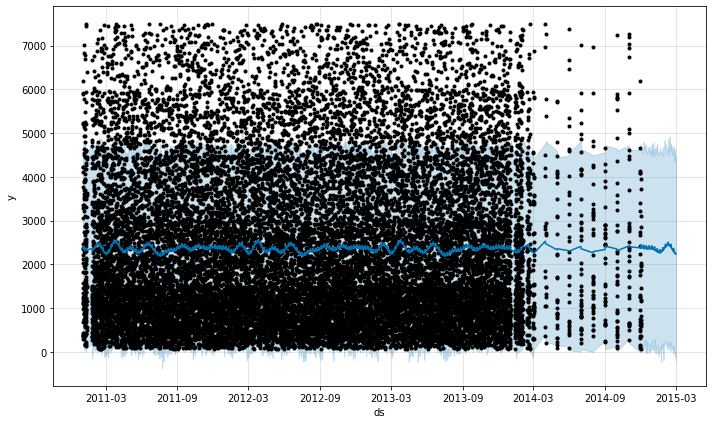

In [ ]:
# Python
fig1 = reg.plot(forecast) 

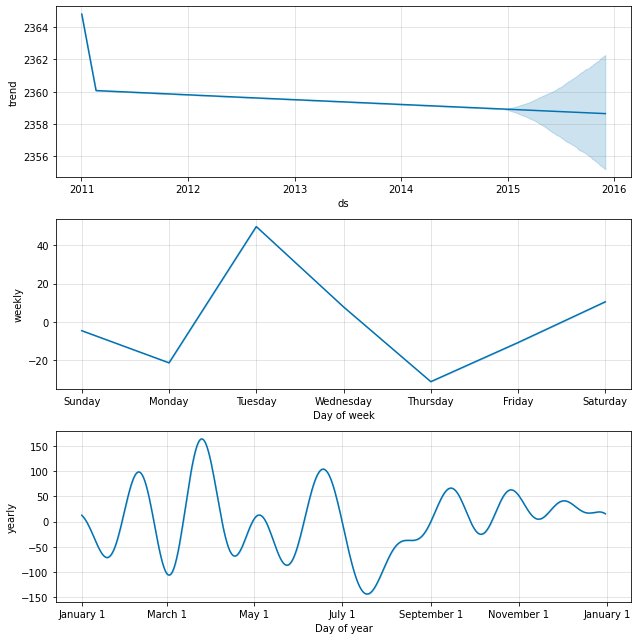

In [ ]:
# Python
fig2 = reg.plot_components(forecast)                                            
